# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [2]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster2"
p_codes = cluster_dict['cluster2']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (4646556, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [3]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (4414593, 39)
Log Train Dataset: (68476, 18)


In [4]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (132207, 4)
Qa Train Dataset: (78641, 13)


In [5]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [6]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (68476, 34)


In [7]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (68476, 34)


In [20]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    'Ct 90_결과',
    'Scorch (T3)_결과',
    'Scorch (T5)_결과',
    'Vm (T3)_결과',
    'Vm (T5)_결과',
    '경도_결과'
]

dataset[target_lst].count()

Ct 90_결과          37190
Scorch (T3)_결과      690
Scorch (T5)_결과       47
Vm (T3)_결과        24820
Vm (T5)_결과           47
경도_결과             51669
dtype: int64

## ***MODELLING***
---

In [22]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch (T3)_결과','Vm (T3)_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset = create_train_test_dataset(dataset, targets[0])

# CT90 
ct_train_dataset, ct_test_dataset = create_train_test_dataset(dataset, targets[1])

# Scorch 
sc_train_dataset, sc_test_dataset = create_train_test_dataset(dataset, targets[2])

# Vm 
vm_train_dataset, vm_test_dataset = create_train_test_dataset(dataset, targets[3])

# Hard 
hard_train_dataset, hard_test_dataset = create_train_test_dataset(dataset, targets[4])

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch (T3)_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm (T3)_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100)

cycle time            |         43,259 |        10,148
Ct 90_결과             |         22,607 |         5,303
Scorch (T3)_결과       |            483 |           114
Vm (T3)_결과           |         15,898 |         3,730
경도_결과               |         34,338 |         8,055


[I 2025-10-20 14:16:04,461] A new study created in memory with name: no-name-e455e6d9-0a06-4eac-84c6-6040b22dc35d


학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 43259


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:16:12,018] Trial 0 finished with value: 3.7818921641102814 and parameters: {'n_estimators': 2657, 'max_depth': 9, 'learning_rate': 0.09870997366371377, 'subsample': 0.7715952911252815, 'gamma': 0.37575063425251354, 'reg_lambda': 0.215648125046722}. Best is trial 0 with value: 3.7818921641102814.
[I 2025-10-20 14:16:14,554] Trial 1 finished with value: 3.78079172993683 and parameters: {'n_estimators': 764, 'max_depth': 7, 'learning_rate': 0.14605848737570024, 'subsample': 0.8092641320120708, 'gamma': 0.4109880426382514, 'reg_lambda': 0.28987773373380055}. Best is trial 1 with value: 3.78079172993683.
[I 2025-10-20 14:16:23,900] Trial 2 finished with value: 4.304337260164456 and parameters: {'n_estimators': 1582, 'max_depth': 8, 'learning_rate': 0.015070836323047343, 'subsample': 0.8242938232979251, 'gamma': 0.053278266493223814, 'reg_lambda': 0.0381792600048873}. Best is trial 1 with value: 3.78079172993683.
[I 2025-10-20 14:16:30,854] Trial 3 finished with value: 3.789

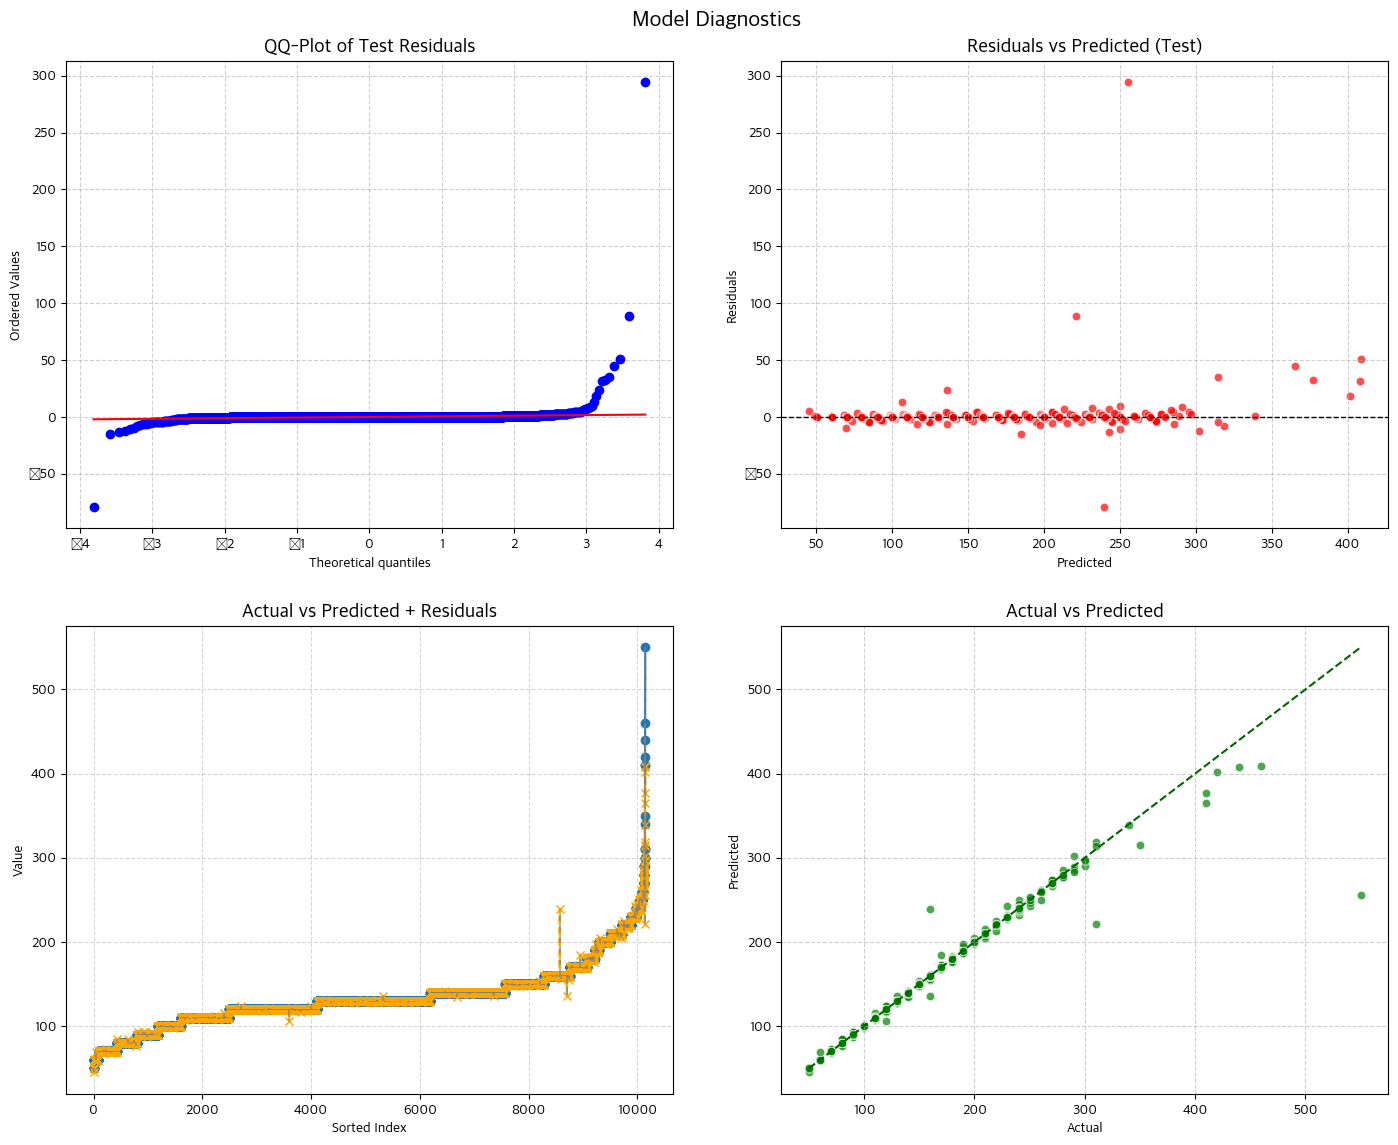

[I 2025-10-20 14:17:31,388] A new study created in memory with name: no-name-bcf84aff-5d28-4d13-a52c-6479109649cf


Train Accuracy
Train RMSE : 0.187
Train R2   : 1.000
Train SMAPE : 0.08
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 3.331
Test R2   : 0.992
Test SMAPE : 0.13
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 22607


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:17:36,233] Trial 0 finished with value: 10.035910385872475 and parameters: {'n_estimators': 816, 'max_depth': 7, 'learning_rate': 0.0028540564698429486, 'subsample': 0.9813445480730694, 'gamma': 0.3239713731044801, 'reg_lambda': 2.079241336028444}. Best is trial 0 with value: 10.035910385872475.
[I 2025-10-20 14:17:57,724] Trial 1 finished with value: 7.59057100017457 and parameters: {'n_estimators': 1632, 'max_depth': 10, 'learning_rate': 0.004327019707255995, 'subsample': 0.7703760908804681, 'gamma': 0.12102895985595935, 'reg_lambda': 1.1827060445610242}. Best is trial 1 with value: 7.59057100017457.
[I 2025-10-20 14:18:16,423] Trial 2 finished with value: 7.546113129796603 and parameters: {'n_estimators': 1997, 'max_depth': 9, 'learning_rate': 0.03645258504283369, 'subsample': 0.7115559193595581, 'gamma': 0.05387752577538579, 'reg_lambda': 0.006542024476411273}. Best is trial 2 with value: 7.546113129796603.
[I 2025-10-20 14:18:31,005] Trial 3 finished with value: 7

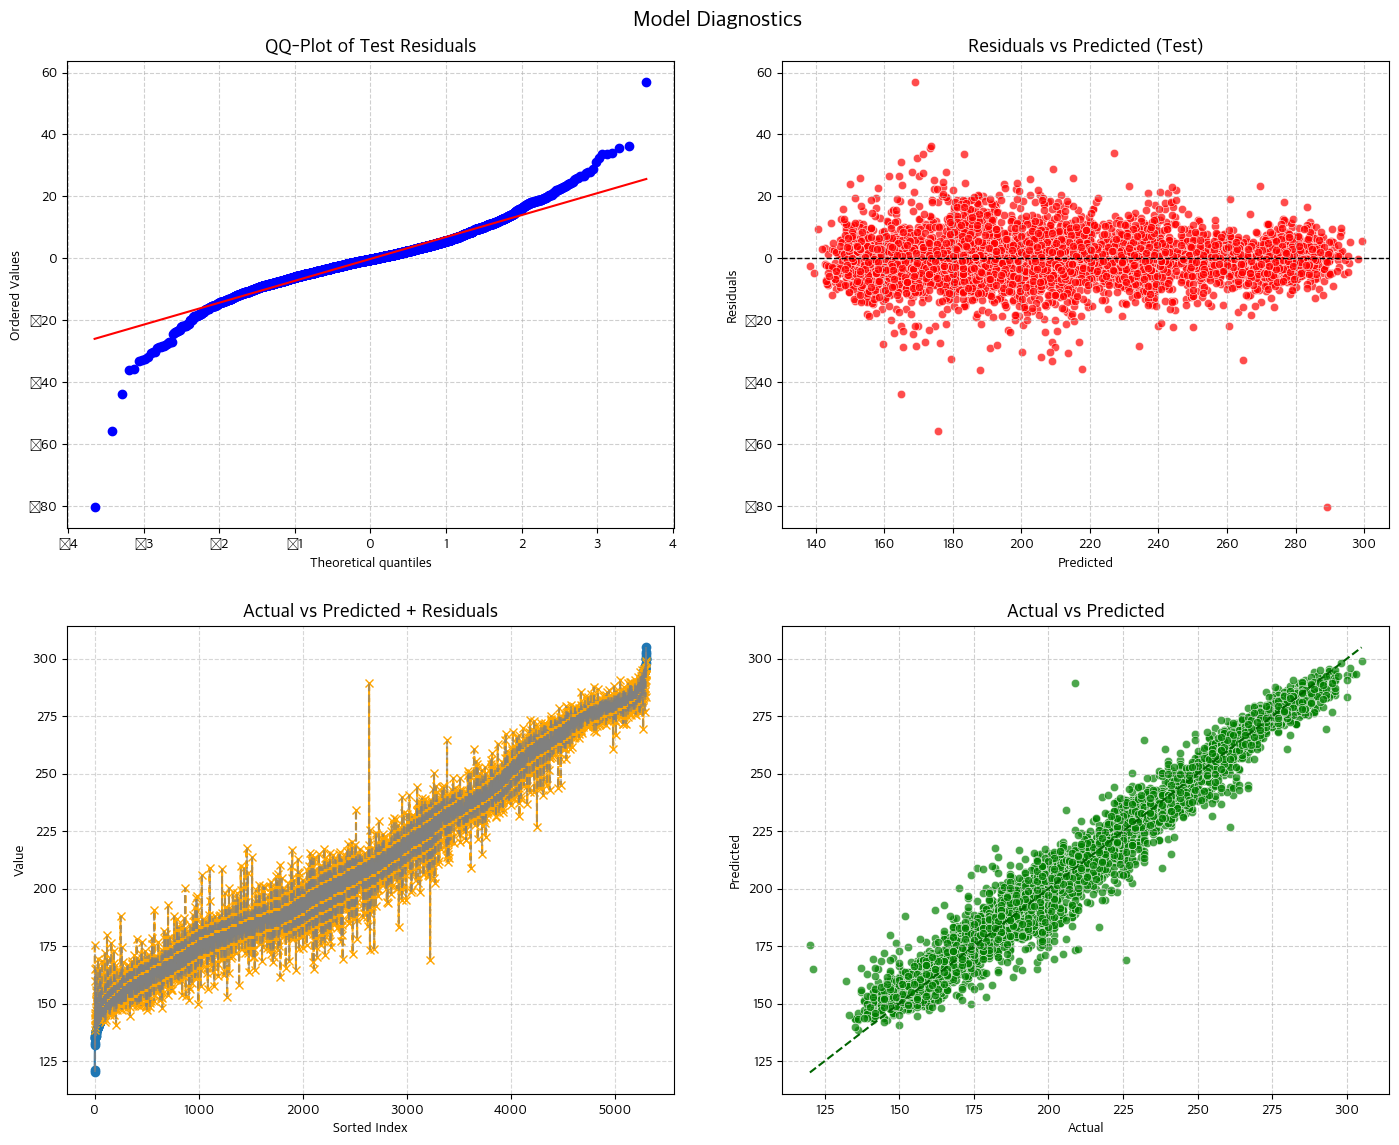

[I 2025-10-20 14:20:27,339] A new study created in memory with name: no-name-3bf1b07e-aa06-418a-acff-19f514f6da77


Train Accuracy
Train RMSE : 2.562
Train R2   : 0.996
Train SMAPE : 0.97
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 7.256
Test R2   : 0.970
Test SMAPE : 2.56
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 483


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:20:28,521] Trial 0 finished with value: 33.00753787125145 and parameters: {'n_estimators': 764, 'max_depth': 9, 'learning_rate': 0.145031159485098, 'subsample': 0.7152173528563092, 'gamma': 0.02940831035952418, 'reg_lambda': 0.646195204504192}. Best is trial 0 with value: 33.00753787125145.
[I 2025-10-20 14:20:37,055] Trial 1 finished with value: 33.17887633288126 and parameters: {'n_estimators': 1998, 'max_depth': 8, 'learning_rate': 0.0013791715774717907, 'subsample': 0.9173414425157904, 'gamma': 0.44403689261082696, 'reg_lambda': 0.03639337404625393}. Best is trial 0 with value: 33.00753787125145.
[I 2025-10-20 14:20:45,029] Trial 2 finished with value: 31.564064119252098 and parameters: {'n_estimators': 2726, 'max_depth': 6, 'learning_rate': 0.0016102893549646508, 'subsample': 0.8163655963544989, 'gamma': 0.15694933081471646, 'reg_lambda': 0.22265281412675061}. Best is trial 2 with value: 31.564064119252098.
[I 2025-10-20 14:20:52,782] Trial 3 finished with value: 

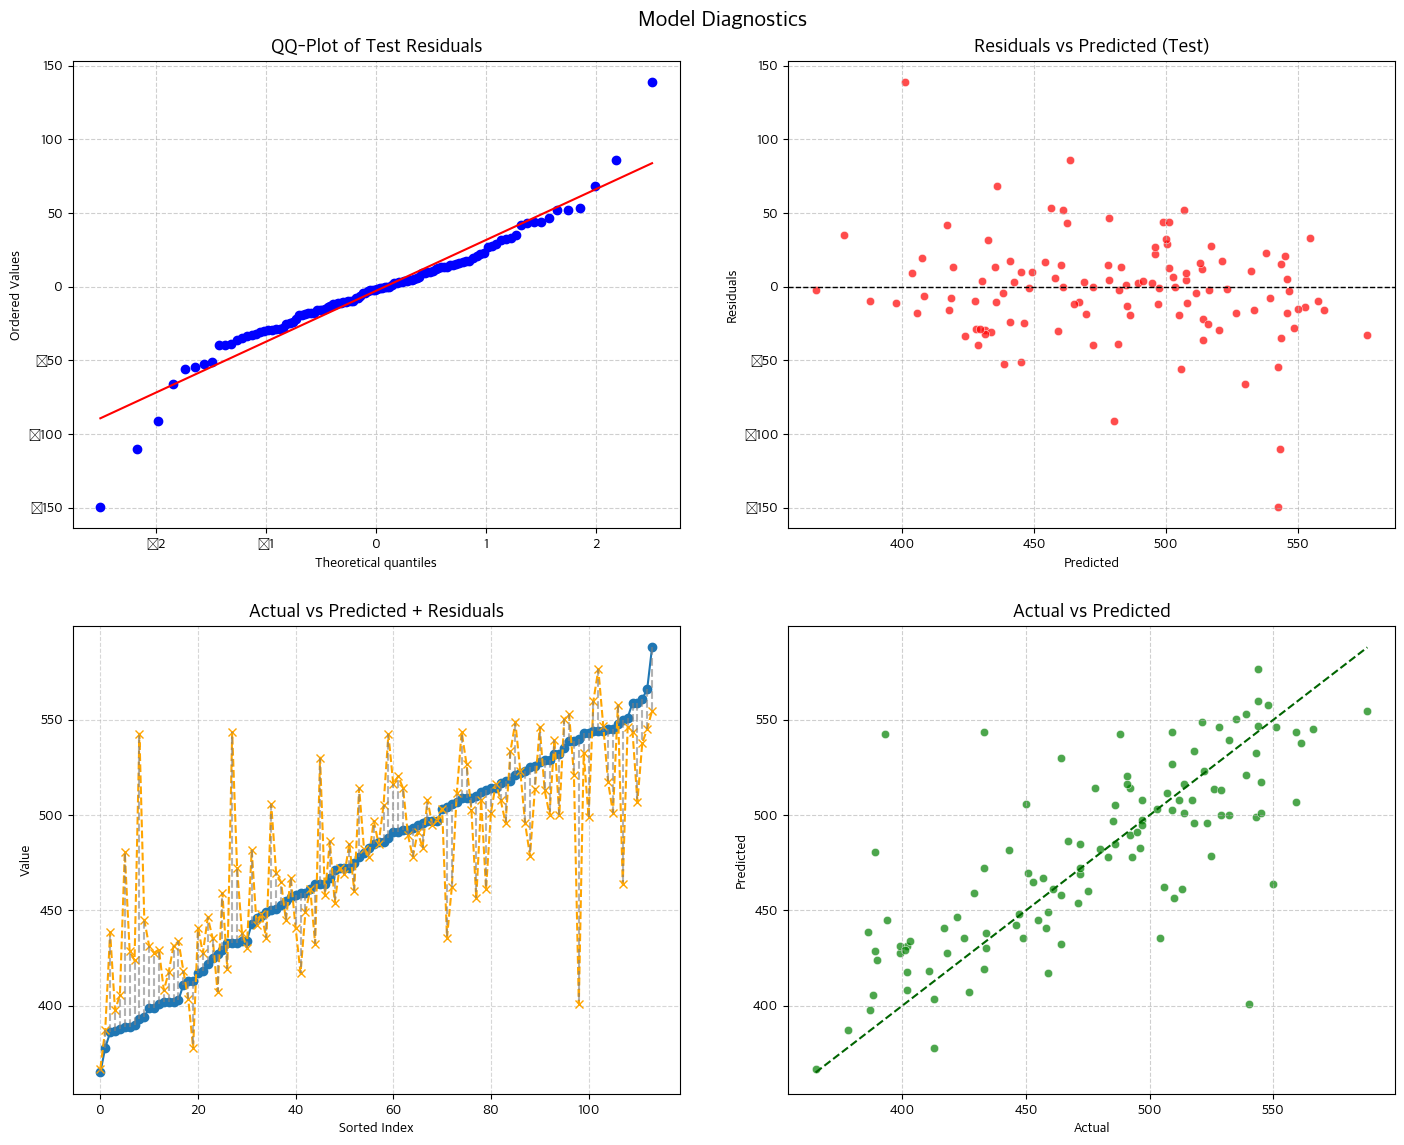

[I 2025-10-20 14:21:12,351] A new study created in memory with name: no-name-fdbb959b-ee54-47f2-9e4c-0f52583634c9


Train Accuracy
Train RMSE : 1.501
Train R2   : 0.999
Train SMAPE : 0.26
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 35.453
Test R2   : 0.554
Test SMAPE : 5.19
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 15898


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:21:14,602] Trial 0 finished with value: 1.0118458506906784 and parameters: {'n_estimators': 755, 'max_depth': 7, 'learning_rate': 0.12388261890202866, 'subsample': 0.7693247710973263, 'gamma': 0.3873108615428953, 'reg_lambda': 0.018388427763608613}. Best is trial 0 with value: 1.0118458506906784.
[I 2025-10-20 14:21:16,032] Trial 1 finished with value: 1.0049061134214023 and parameters: {'n_estimators': 336, 'max_depth': 7, 'learning_rate': 0.19242766165376593, 'subsample': 0.9439521778120624, 'gamma': 0.09550155532328436, 'reg_lambda': 0.0019841365242407407}. Best is trial 1 with value: 1.0049061134214023.
[I 2025-10-20 14:21:39,613] Trial 2 finished with value: 1.9514403568350198 and parameters: {'n_estimators': 1035, 'max_depth': 12, 'learning_rate': 0.0012351067419425373, 'subsample': 0.7201299323230578, 'gamma': 0.002126974477829946, 'reg_lambda': 0.0010567862646652481}. Best is trial 1 with value: 1.0049061134214023.
[I 2025-10-20 14:21:43,832] Trial 3 finished w

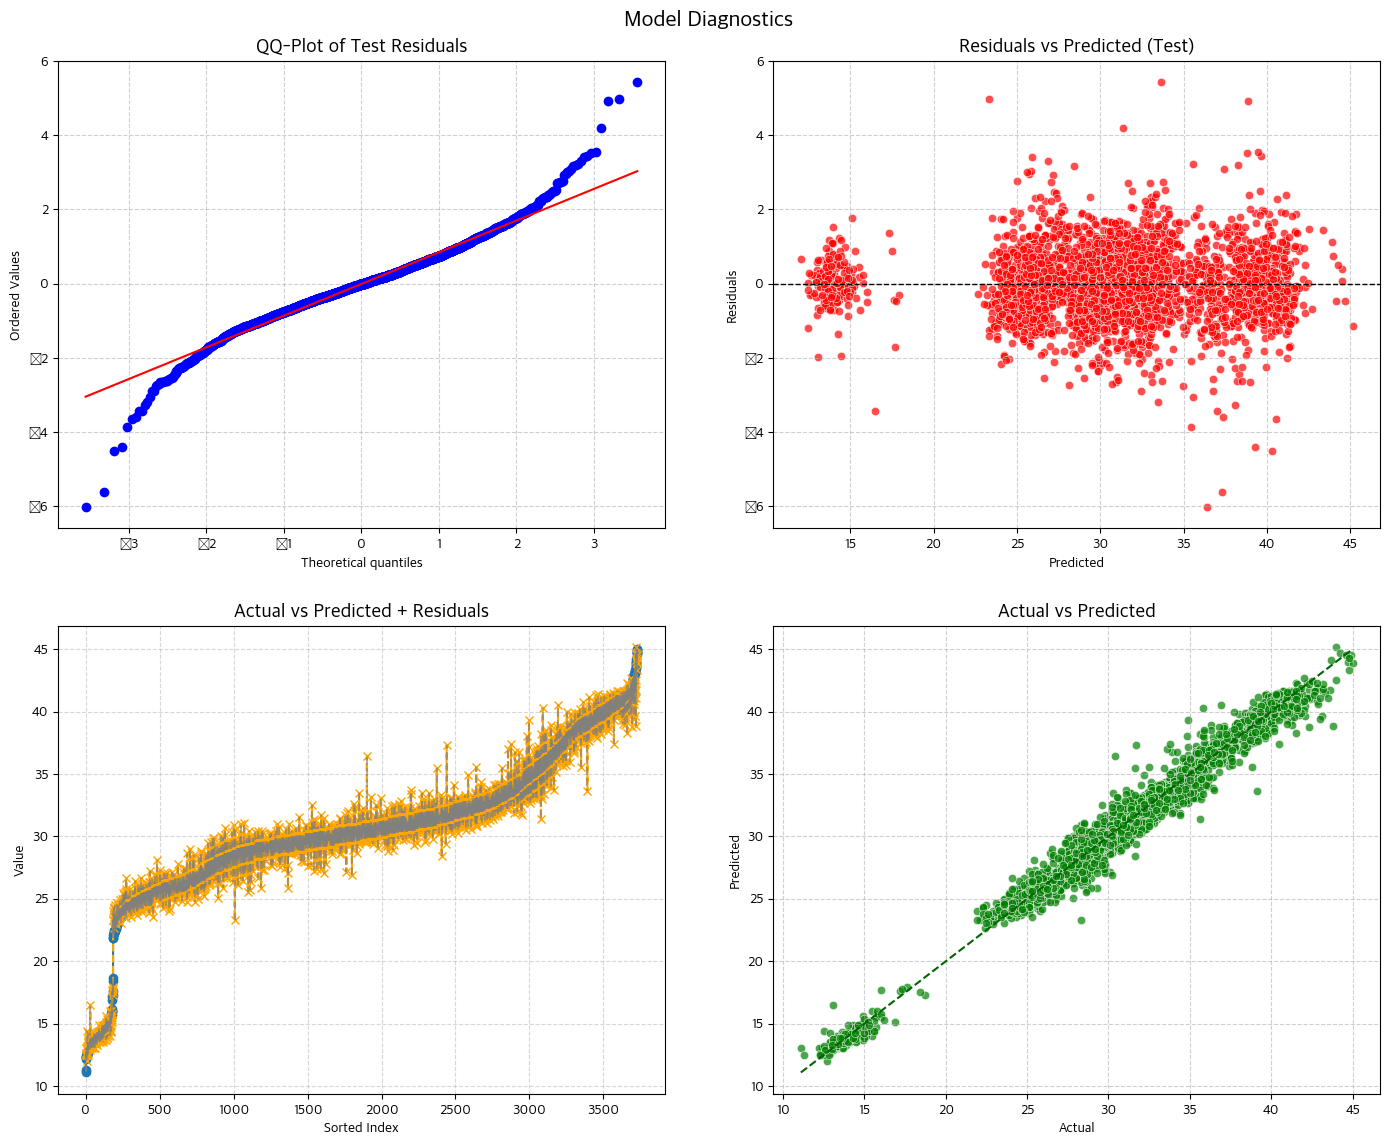

[I 2025-10-20 14:22:20,968] A new study created in memory with name: no-name-c1f49ead-f7ac-45d2-897b-ba52bcd44fb7


Train Accuracy
Train RMSE : 0.314
Train R2   : 0.997
Train SMAPE : 0.84
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 0.866
Test R2   : 0.978
Test SMAPE : 2.14
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 34338


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:22:28,996] Trial 0 finished with value: 1.042740000288288 and parameters: {'n_estimators': 1643, 'max_depth': 8, 'learning_rate': 0.03667488449990653, 'subsample': 0.9303007122924077, 'gamma': 0.36515998114830006, 'reg_lambda': 0.6426582633821958}. Best is trial 0 with value: 1.042740000288288.
[I 2025-10-20 14:22:42,646] Trial 1 finished with value: 1.0495874642931942 and parameters: {'n_estimators': 831, 'max_depth': 12, 'learning_rate': 0.02482077188245022, 'subsample': 0.8227923203306114, 'gamma': 0.13000955074577625, 'reg_lambda': 2.1430324178164377}. Best is trial 0 with value: 1.042740000288288.
[I 2025-10-20 14:22:50,796] Trial 2 finished with value: 1.069742215019467 and parameters: {'n_estimators': 1689, 'max_depth': 9, 'learning_rate': 0.08893600089149523, 'subsample': 0.8413582100923339, 'gamma': 0.059110109194549454, 'reg_lambda': 0.0060407293342588835}. Best is trial 0 with value: 1.042740000288288.
[I 2025-10-20 14:22:57,889] Trial 3 finished with value:

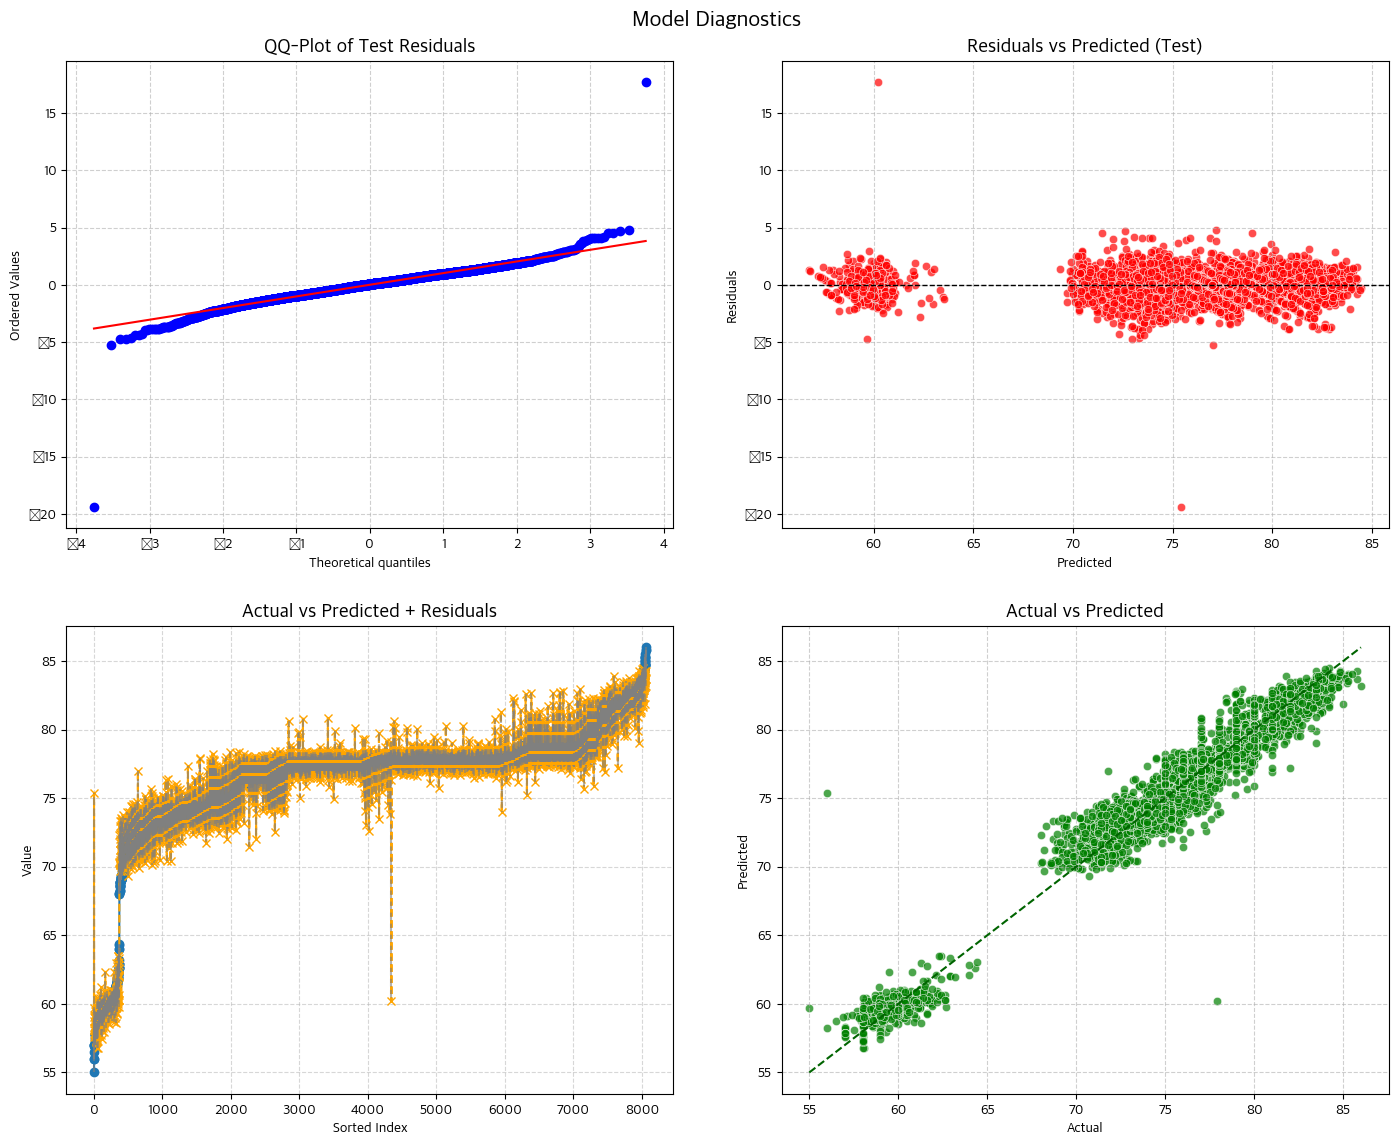

Train Accuracy
Train RMSE : 0.590
Train R2   : 0.983
Train SMAPE : 0.62
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.048
Test R2   : 0.946
Test SMAPE : 1.04


In [24]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch (T3)_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm (T3)_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과')

In [25]:
### Feature Importance 
print('='*100)
print('Cycle Time')
print(cycle_importance)
print('-'*100)
print('CT90')
print(ct_importance)
print('-'*100)
print('Scorch')
print(sc_importance)
print('-'*100)
print('점도')
print(vm_importance)
print('-'*100)
print('경도')
print(hard_importance)
print('='*100)

Cycle Time
              Feature  Importance  rank
0          step2_time    0.381386     1
1          step3_time    0.216490     2
2           step3_전력량    0.183601     3
3   step3_Rotor speed    0.111074     4
4          step1_time    0.035797     5
5           step2_전력량    0.019579     6
6         step1_mix온도    0.018954     7
7         step3_mix온도    0.013606     8
8                 필팩터    0.007265     9
9         step2_mix온도    0.004432    10
10  step1_Rotor speed    0.003141    11
11  step2_Rotor speed    0.002046    12
12       step1_Ram 압력    0.001106    13
13       step2_Ram 압력    0.000729    14
14          step1_전력량    0.000378    15
15             TA_MIN    0.000215    16
16             TA_AVG    0.000129    17
17       step3_Ram 압력    0.000045    18
18             TA_MAX    0.000025    19
----------------------------------------------------------------------------------------------------
CT90
              Feature  Importance  rank
0   step3_Rotor speed    0.866128     1
1  

[I 2025-10-20 14:48:49,781] A new study created in memory with name: no-name-88157ac9-94f6-42f1-b523-2db690425727


학습할 Tree Features: 8 | ['step1_Ram 압력', 'step1_Rotor speed', 'step1_mix온도', 'step1_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 41671


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:48:56,913] Trial 0 finished with value: 2.8264984284487586 and parameters: {'n_estimators': 1403, 'max_depth': 7, 'learning_rate': 0.04660476947108054, 'subsample': 0.8089773497040917, 'gamma': 0.16695022833093548, 'reg_lambda': 0.0029948944060102676}. Best is trial 0 with value: 2.8264984284487586.
[I 2025-10-20 14:49:03,678] Trial 1 finished with value: 2.8552093080689693 and parameters: {'n_estimators': 1559, 'max_depth': 6, 'learning_rate': 0.00348939493678823, 'subsample': 0.8133882458605436, 'gamma': 0.23685362905544372, 'reg_lambda': 0.37629898575077125}. Best is trial 0 with value: 2.8264984284487586.
[I 2025-10-20 14:49:08,849] Trial 2 finished with value: 2.8112489442929864 and parameters: {'n_estimators': 1250, 'max_depth': 7, 'learning_rate': 0.08401748218886228, 'subsample': 0.7500513344537334, 'gamma': 0.19410006459346718, 'reg_lambda': 0.08144541643059039}. Best is trial 2 with value: 2.8112489442929864.
[I 2025-10-20 14:49:20,684] Trial 3 finished with 

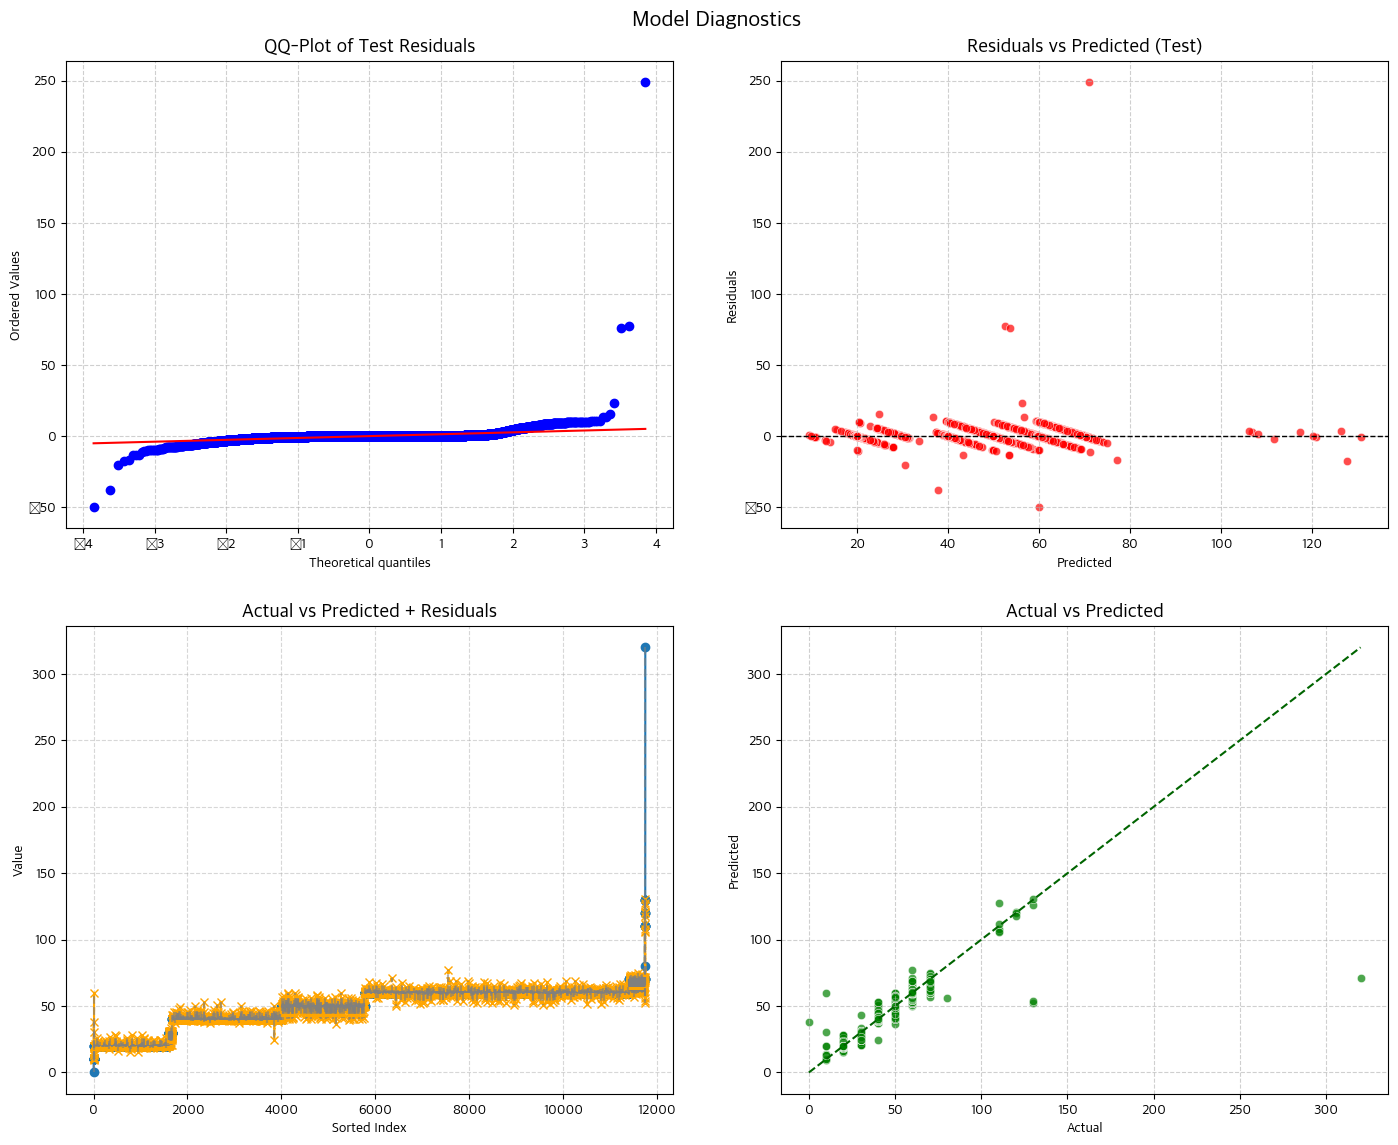

[I 2025-10-20 14:50:03,686] A new study created in memory with name: no-name-132d95bd-96d4-4acb-9ed9-3621eef9a7b7


Train Accuracy
Train RMSE : 0.301
Train R2   : 1.000
Train SMAPE : 0.38
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 3.018
Test R2   : 0.958
Test SMAPE : 1.35
학습할 Tree Features: 8 | ['step2_Ram 압력', 'step2_Rotor speed', 'step2_mix온도', 'step2_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 41668


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:50:18,291] Trial 0 finished with value: 11.14184941259524 and parameters: {'n_estimators': 911, 'max_depth': 12, 'learning_rate': 0.0011906281605953356, 'subsample': 0.8006307328191544, 'gamma': 0.00986750217578053, 'reg_lambda': 0.01340218673003059}. Best is trial 0 with value: 11.14184941259524.
[I 2025-10-20 14:50:27,974] Trial 1 finished with value: 5.804062657722175 and parameters: {'n_estimators': 1876, 'max_depth': 7, 'learning_rate': 0.03339302169299943, 'subsample': 0.9797854380058504, 'gamma': 0.30927907997140863, 'reg_lambda': 0.06027498766629983}. Best is trial 1 with value: 5.804062657722175.
[I 2025-10-20 14:50:36,103] Trial 2 finished with value: 6.122516698483363 and parameters: {'n_estimators': 2238, 'max_depth': 11, 'learning_rate': 0.07748771912792049, 'subsample': 0.9557585023710182, 'gamma': 0.21490252430957163, 'reg_lambda': 0.0022381204144920966}. Best is trial 1 with value: 5.804062657722175.
[I 2025-10-20 14:50:40,717] Trial 3 finished with val

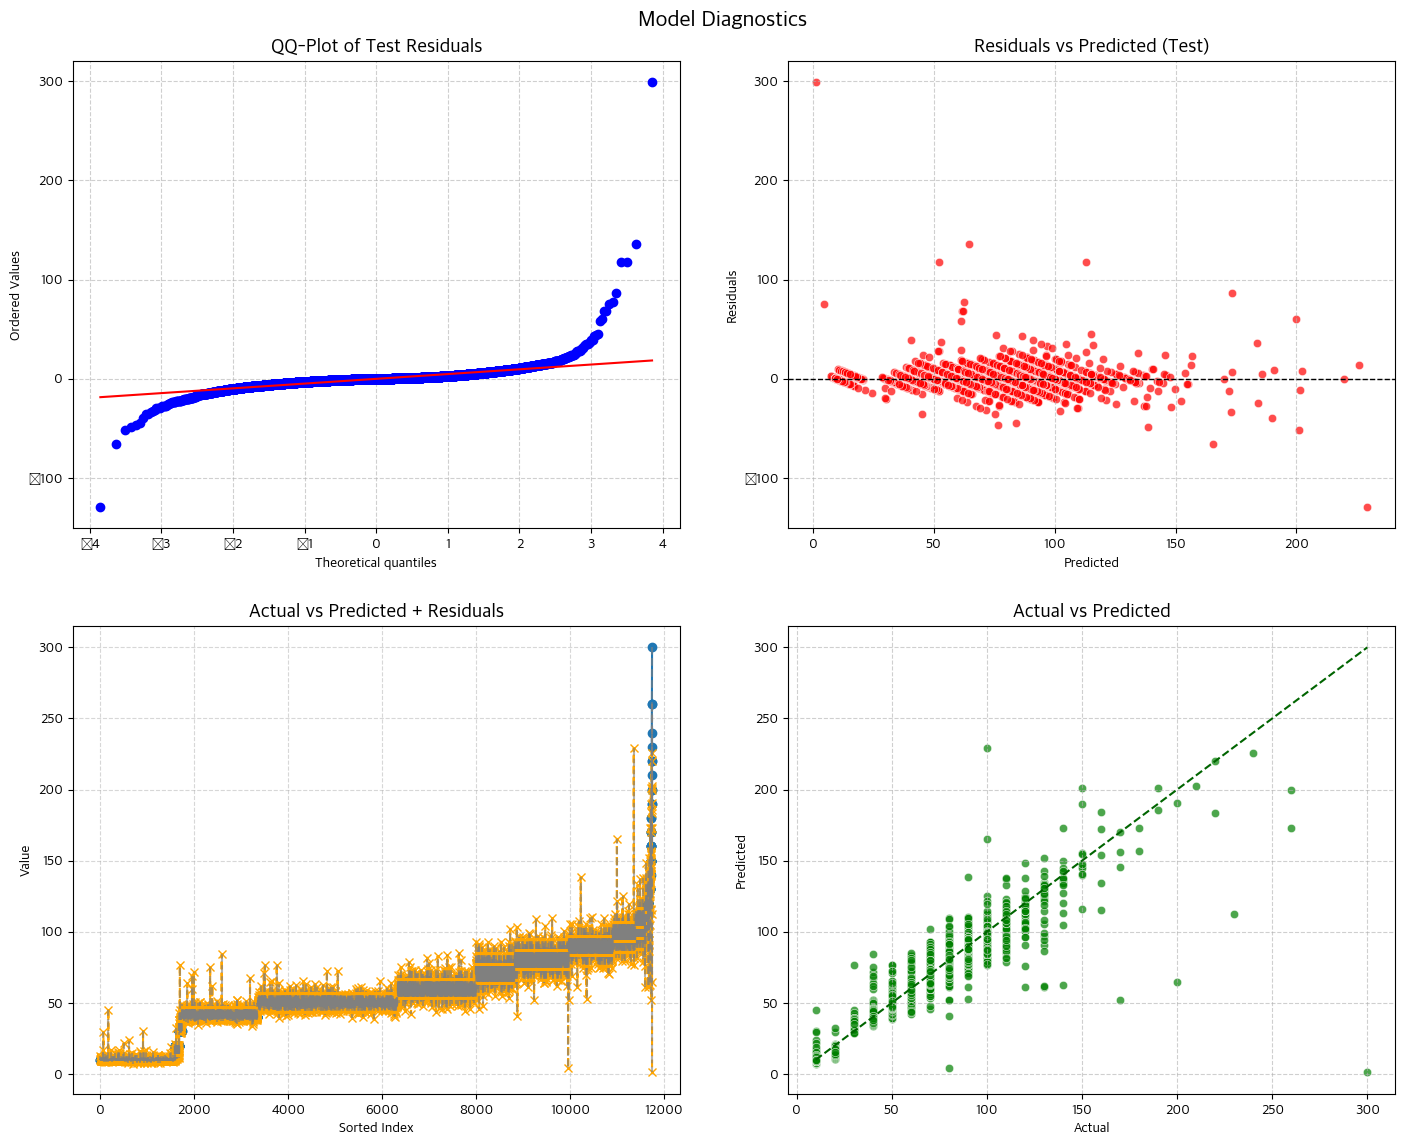

[I 2025-10-20 14:51:56,017] A new study created in memory with name: no-name-37b47ae8-eeec-4168-9c0e-5de2e1c4489e


Train Accuracy
Train RMSE : 3.100
Train R2   : 0.987
Train SMAPE : 3.91
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 6.289
Test R2   : 0.946
Test SMAPE : 5.31
학습할 Tree Features: 8 | ['step3_Ram 압력', 'step3_Rotor speed', 'step3_mix온도', 'step3_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 41657


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:51:58,596] Trial 0 finished with value: 14.798248106571663 and parameters: {'n_estimators': 346, 'max_depth': 8, 'learning_rate': 0.0019785754876299345, 'subsample': 0.92835275021944, 'gamma': 0.055659406409193424, 'reg_lambda': 0.3282338143780439}. Best is trial 0 with value: 14.798248106571663.
[I 2025-10-20 14:52:02,020] Trial 1 finished with value: 10.637736453213456 and parameters: {'n_estimators': 342, 'max_depth': 10, 'learning_rate': 0.004124751558348272, 'subsample': 0.9057030176123393, 'gamma': 0.4295733069303105, 'reg_lambda': 1.4794758077319725}. Best is trial 1 with value: 10.637736453213456.
[I 2025-10-20 14:52:13,822] Trial 2 finished with value: 9.420946127941312 and parameters: {'n_estimators': 2136, 'max_depth': 7, 'learning_rate': 0.0010683333585307674, 'subsample': 0.8856350142760927, 'gamma': 0.4944630067560892, 'reg_lambda': 0.057142830268113405}. Best is trial 2 with value: 9.420946127941312.
[I 2025-10-20 14:52:27,043] Trial 3 finished with valu

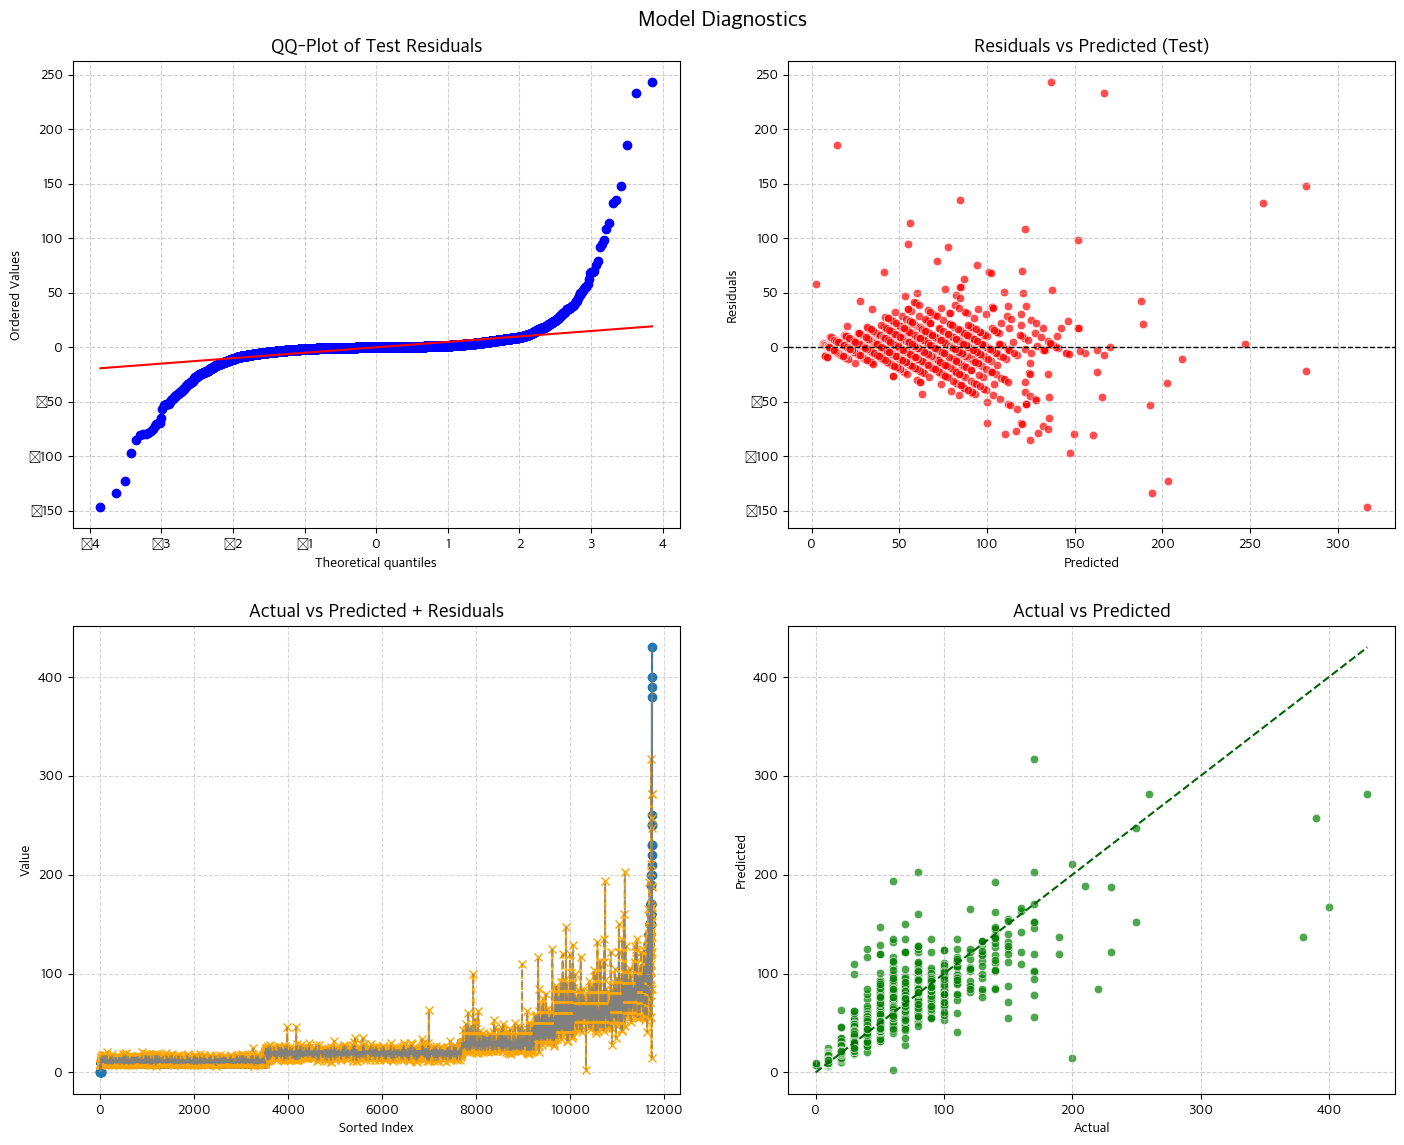

Train Accuracy
Train RMSE : 1.014
Train R2   : 0.998
Train SMAPE : 3.47
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 8.030
Test R2   : 0.889
Test SMAPE : 8.15


In [39]:
### Step1 Time 모델링 
# Step 1 
step1_model, step1_importance = step_time_modelling(dataset, step_time='step1_time')

# Step 2
step2_model, step2_importance = step_time_modelling(dataset, step_time='step2_time')

# Step 3 
step3_model, step3_importance = step_time_modelling(dataset, step_time='step3_time')

In [40]:
### Feature Importance 
print('='*100)
print('Step1_time')
print(step1_importance)
print('-'*100)
print('Step2_time')
print(step2_importance)
print('-'*100)
print('Step3_time')
print(step3_importance)
print('='*100)

Step1_time
             Feature  Importance  rank
0  step1_Rotor speed    0.834371     1
1          step1_전력량    0.124898     2
2       step1_Ram 압력    0.013280     3
3        step1_mix온도    0.007083     4
4                필팩터    0.006854     5
5             TA_AVG    0.005404     6
6             TA_MAX    0.004269     7
7             TA_MIN    0.003841     8
----------------------------------------------------------------------------------------------------
Step2_time
             Feature  Importance  rank
0          step2_전력량    0.362961     1
1  step2_Rotor speed    0.295597     2
2        step2_mix온도    0.137277     3
3                필팩터    0.132942     4
4             TA_MAX    0.022882     5
5             TA_AVG    0.021578     6
6             TA_MIN    0.019214     7
7       step2_Ram 압력    0.007549     8
----------------------------------------------------------------------------------------------------
Step3_time
             Feature  Importance  rank
0  step3_Rotor speed    